In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
IMG_FOLDER = 'filestore/analysis_output/img/'

In [3]:
events = pd.read_csv("./filestore/events/fact_events.csv").drop('Unnamed: 0', axis=1)

In [4]:
events.head()

,description,duration,headcount,event_id,maybe_rsvp_count,name,rating,rsvp_limit,status,time,updated,utc_offset,venue_id,visibility,waitlist_count,yes_rsvp_count
0,These meetups are very informal. I won't be st...,9000000.0,12,147478282,0,PyLadies Dublin Inaugural meetup - bring laptop!,NaN,NaN,past,1384799400000,1384853013000,0,16176442,public,0,22
1,"Our second meetup will be at Engine Yard, a bi...",NaN,0,152107272,0,Second PyLadies Dublin Meetup - Let's get coding!,NaN,NaN,past,1387218600000,1387230236000,0,13054852,public,0,12
2,Happy New Year! Hope you all had a good Christ...,10800000.0,0,159368332,0,Our first PyLadies Dublin meetup of 2014,NaN,NaN,past,1390240800000,1390470097000,0,17757332,public,0,11
3,Bring your laptops along. If you want some foo...,10800000.0,0,162851382,0,PyLadies Dublin Feb meetup,NaN,NaN,past,1392660000000,1392672314000,0,18096492,public,0,9
4,!!!CHANGE OF VENUE UPDATE!!! &gt;&gt; More inf...,10800000.0,0,166955082,0,PyLadies Dublin Meetup,NaN,NaN,past,1395165600000,1395219566000,0,18950322,public,0,11


In [5]:
events.dtypes

description          object
duration            float64
headcount             int64
event_id             object
maybe_rsvp_count      int64
name                 object
rating              float64
rsvp_limit          float64
status               object
time                  int64
updated               int64
utc_offset            int64
venue_id              int64
visibility           object
waitlist_count        int64
yes_rsvp_count        int64
dtype: object

# Let's look at the event descriptions

In [6]:
desc = events['description'].tolist()
desc[:4]

["These meetups are very informal. I won't be structuring until we get a feel on what we want/like to do. It all depends on who shows up. :-) So bring your laptop and please have Python installed, and we will do a quick introduction and get stuck in why we use Python, and start from there. They have free wi-fi (via bitbuzz) but that means we have to log in every 30 minutes. And we will be upstairs.",
 "Our second meetup will be at Engine Yard, a big thanks to Eamon and Jonathan for helping us out. So a few things:- • The meetup will be from 6:30PM to 9PM. •\xa0It's free to attend. • Bring your laptop. • If you have an idea and/or project, problems, bring them along. • We will be running through what source control is about, and for those who haven't set up their github account, please do so and email [masked] you username so I can add you to PyLadies Dublin github team. • Guys are welcome as well. :-D Venue thanks to Engine Yard:  Food thanks to Python Ireland: ",
 'Happy New Year! Hop

## Cleaning up the description

### Unicode, URLS, smiley faces

In [7]:
special_dict = {
    'smile' : r'[:;=]-[)D]?',
    'uni' : r'\xa0',
    'url' : r'(?:https?|ftp|file)://\S+',
    'uls_chars' :  r'(?:&[gla][tm]p?)+',
    'dupe_space' : r'\s{2,}|\s+\Z'
}

def remove_special(s):
    for k, regex in special_dict.items():
        if k == 'uni':
            s = re.sub(regex, ' ', s)
        elif k == 'dupe_space':
            s = re.sub(regex, ' ', s)
        else:
            s = re.sub(regex, '', s)
    return s

clean_special = [remove_special(s) for s in desc]

### Punctuation and emojis
There are some emoji characters and unwanted punctuation

In [8]:
def find_unwanted_chars(s):
    pattern = r"[^a-zA-Z0-9\s/@€$_Éáéóć%]"
    return set(re.findall(pattern, s))

unwanted = set(char for e in desc for char in find_unwanted_chars(e))
clean_punct = []

for sent in clean_special:
    for punct in unwanted:
        sent = sent.replace(punct, "")
    clean_punct.append(sent)

# Removing words that have digits

Reason for this is that after tokenizing, I found that there are tokens which consist of digits (perhaps meetup start/end times)

In [9]:
def remove_digits(s):
    pattern = re.compile(r'\b(?:\d+\S+|\S+\d+)\b')
    return re.sub(pattern, '', s)

clean_digits = [remove_digits(s) for s in clean_punct]

# Cleaning duplicate spaces

In [10]:
regex = r'\s{2,}|\s+\Z'
event_corpus = [re.sub(regex, ' ', s).lower() for s in clean_digits]

# NLP to clean the text

In [11]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en')

In [12]:
nlp_corpus = [nlp(sent) for sent in event_corpus]

In [13]:
entity_dict = {}
for entry in nlp_corpus:
    for entity in entry.ents:
        try:
            entity_dict[entity.label_].append(entity.text)
        except:
            entity_dict[entity.label_] = [entity.text]

In [14]:
entity_dict.keys()

dict_keys(['TIME', 'ORDINAL', 'DATE', 'MONEY', 'CARDINAL'])

In [15]:
lemmatized_corpus = [ ' '.join(word.lemma_.lower() if word.lemma_ != '-PRON-' else word.text for word in sent) for sent in nlp_corpus]

## Tokenizing and removing stop words

In [178]:
event_text = event_corpus

In [179]:
en_stopwords = stopwords.words('english')

In [180]:
from lda_stopwords import extra_stopwords
en_stopwords = en_stopwords + extra_stopwords

Vectorizer splits our documents into a distribution of words.
 
X is a term document matrix, where each document is a column and words are rows. The value associated to each cell is the TF-IDF

In [181]:
lemma_vectorizer = TfidfVectorizer(stop_words = set(en_stopwords))
lemma_dtm = lemma_vectorizer.fit_transform(lemmatized_corpus)

In [182]:
tfidf_vectorizer = TfidfVectorizer(stop_words = en_stopwords)
tfidf_dtm = tfidf_vectorizer.fit_transform(event_text)

The vectorizer we got above is used as input for LDA or NMF to build the model

# Exploring K-means Clustering

In [183]:
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist 

Since we don't have an idea of how many topics can there be, let's use the silhouette score as a measure of how many clusters we should have.

In [184]:
# clusters = range(2,30)
# distortions = []
# silhouette_coeffs = []

# for k in clusters:
#     km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10,verbose=0)
#     km.fit(tfidf_dtm)
    
#     distortions.append(km.inertia_)
#     silhouette_coeffs.append(metrics.silhouette_score(tfidf_dtm, km.labels_))

In [185]:
# plt.style.use('seaborn-darkgrid')
# fig, ax = plt.subplots(figsize=(8,6))
# fname = ' K-means elbow method.png'

# ax.plot(clusters, distortions, marker='o', color='b')
# plt.show()
# plt.savefig(IMG_FOLDER+fname)

In [186]:
# plt.style.use('seaborn-darkgrid')
# fig, ax = plt.subplots(figsize=(8,6))
# fname = ' K-means silhouette.png'

# ax.bar(x=clusters, height=silhouette_coeffs, color='g')
# plt.show()
# plt.savefig(IMG_FOLDER+fname)

It seems that the preprocessing done was not enough and the k-means algorithm is being too sensitive to the data. It could be worthwhile trying to extract the event descriptions manually as there are only 70 ish events...

Below a sample clustering for k=15, doesn't seem good.

In [187]:
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vectorizer.get_feature_names()

# for i in range(15):
#     print("Cluster %d:" % i, end='')
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind], end='')
#     print()

# Exploring LDA

In [188]:
count_vectorizer = CountVectorizer(stop_words = set(en_stopwords))
X_count = count_vectorizer.fit_transform(event_text)

In [189]:
count_df = pd.DataFrame(X_count.toarray(), columns= count_vectorizer.get_feature_names())

In [190]:
agg_counts = pd.DataFrame({
    'word' : count_vectorizer.get_feature_names(),
    'count' : count_df.T.apply(np.sum, axis=1)
}).reset_index(drop=True)

In [191]:
feats = count_vectorizer.get_feature_names()
digits = re.compile(r'^\d+')

print(f"There are {len(feats)} feature names.")
print(f"Of which {len([re.match(digits, f) for f in feats if re.match(digits, f)])} \
start with digits and might be noisy values")

There are 2088 feature names.
Of which 0 start with digits and might be noisy values


In [192]:
# agg_counts.sort_values('count', ascending=False).iloc[:50,:]

From looking at the counts above, the text quality doesn't look good. I will apply some manual cleansing to the description to get a more accurate representation of the Event descriptions

In [193]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [194]:
# Helper function
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        topic_themes = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(topic_themes)
        topic_dict[topic_idx] = [topic_themes]
    return topic_dict


First, an attempt with just the CountVectorizer

In [195]:
# Tweak the two parameters below
number_topics = 10
number_words = 10
jobs = -1
max_iter = 25
seed = 33267415

alpha = None
eta = None

In [196]:
# Create and fit the LDA model
tfidf_lda = LDA(
    doc_topic_prior = alpha, 
    topic_word_prior = eta, 
    n_components=number_topics, 
    n_jobs = jobs, 
    max_iter=max_iter,
    random_state=seed
)
tfidf_lda.fit(tfidf_dtm)

# Print the topics found by the LDA model
print("Topics found via LDA with tfidf vectorizer:")
tfidf_topics = print_topics(tfidf_lda, tfidf_vectorizer, number_words)

Topics found via LDA with tfidf vectorizer:

Topic #0:
ai table group micropython coder etsy landscape hub promoting supported

Topic #1:
django prizes website quiz udemy still makers group form contribute

Topic #2:
patch udemy submitting inheritance metaclasses multiple chat cpython connected smart

Topic #3:
mailing pythony discussions sharing metricfire engineers list society professional skills

Topic #4:
link tribalvc post still website vaults downstairs install windows foundation

Topic #5:
free bring meetup projects notes workshop laptop food work us

Topic #6:
products communication marketing customers customer targeted teams disjointed emailthis enable

Topic #7:
micropython pitops electronics books microcontrollers continue finish kits early microbits

Topic #8:
ai kdb salon problems creation image engine github phorest tool

Topic #9:
kx cryptoparty kindly accessibility lift opened wraps canal sandwiches jupyter


In [197]:
# # Create and fit the LDA model with lemmatized text
# lemmatized_lda = LDA(
#     doc_topic_prior = alpha, 
#     topic_word_prior = eta,
#     n_components=number_topics, 
#     n_jobs = jobs, 
#     max_iter=max_iter
# )
# lemmatized_lda.fit(lemma_dtm)

# # Print the topics found by the LDA model
# print("Topics found via LDA with lemmatized vectorizer:")
# lemmatized_topics = print_topics(lemmatized_lda, lemma_vectorizer, number_words)

In [198]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [199]:
# tfidf_vis = pyLDAvis.sklearn.prepare(tfidf_lda, tfidf_dtm, tfidf_vectorizer)
# pyLDAvis.save_html(tfidf_vis, IMG_FOLDER + 'LDAvis tfidf.html')

In [200]:
# lemma_vis = pyLDAvis.sklearn.prepare(lemmatized_lda, lemma_dtm, lemma_vectorizer)
# pyLDAvis.save_html(lemma_vis, IMG_FOLDER + 'LDAvis lemmatized.html')

## Classifying our data

In [201]:
# Creates DF with mapping between topic # and topic names
topic_df = (
    pd.DataFrame(tfidf_topics)
    .T
    .reset_index()
    .rename(columns={'index':'topic_id', 0: 'topic'})
)

In [202]:
# Create document term matrix from event dataset
tfidf_categorised = tfidf_lda.transform(tfidf_vectorizer.transform(event_text))

In [203]:
# Creates dataframe with doc_id, topic, topic likelihood
tfidf_df = (
    pd.melt(
        pd.DataFrame(tfidf_categorised).reset_index(),
        id_vars=['index'],
        var_name=['topic_id'],
        value_name='likelihood')
    .rename(columns = {'index' : 'doc_id'})
    .sort_values(by=['doc_id', 'topic_id'])
    .reset_index(drop=True)
)

In [204]:
pyl_topics = pd.merge(tfidf_df, topic_df, on='topic_id', how='inner', validate='m:1', copy=False)

In [205]:
n=3
top_n_topics_per_doc = pyl_topics\
    .groupby('doc_id')\
    .apply(lambda x: x.sort_values('likelihood', ascending=False))\
    .reset_index(drop=True)\
    .groupby('doc_id')\
    .head(n)

In [206]:
orig_events = events['description'].reset_index().rename(columns={'index':'doc_id'})

In [207]:
clustered_events = pd.merge(
        orig_events,
        top_n_topics_per_doc,
        on='doc_id',
        how='inner',
        validate='1:m',
        copy=False
    )
clustered_events.to_excel('filestore/analysis_output/clustered_events.xlsx', index=False)

# Plot the document topic distribution as a matrix

In [208]:
import warnings
warnings.simplefilter("ignore")

In [209]:
cmap = cm.get_cmap('plasma', 75)
rgb_arr = [cmap.colors[x] for x in range(75)]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

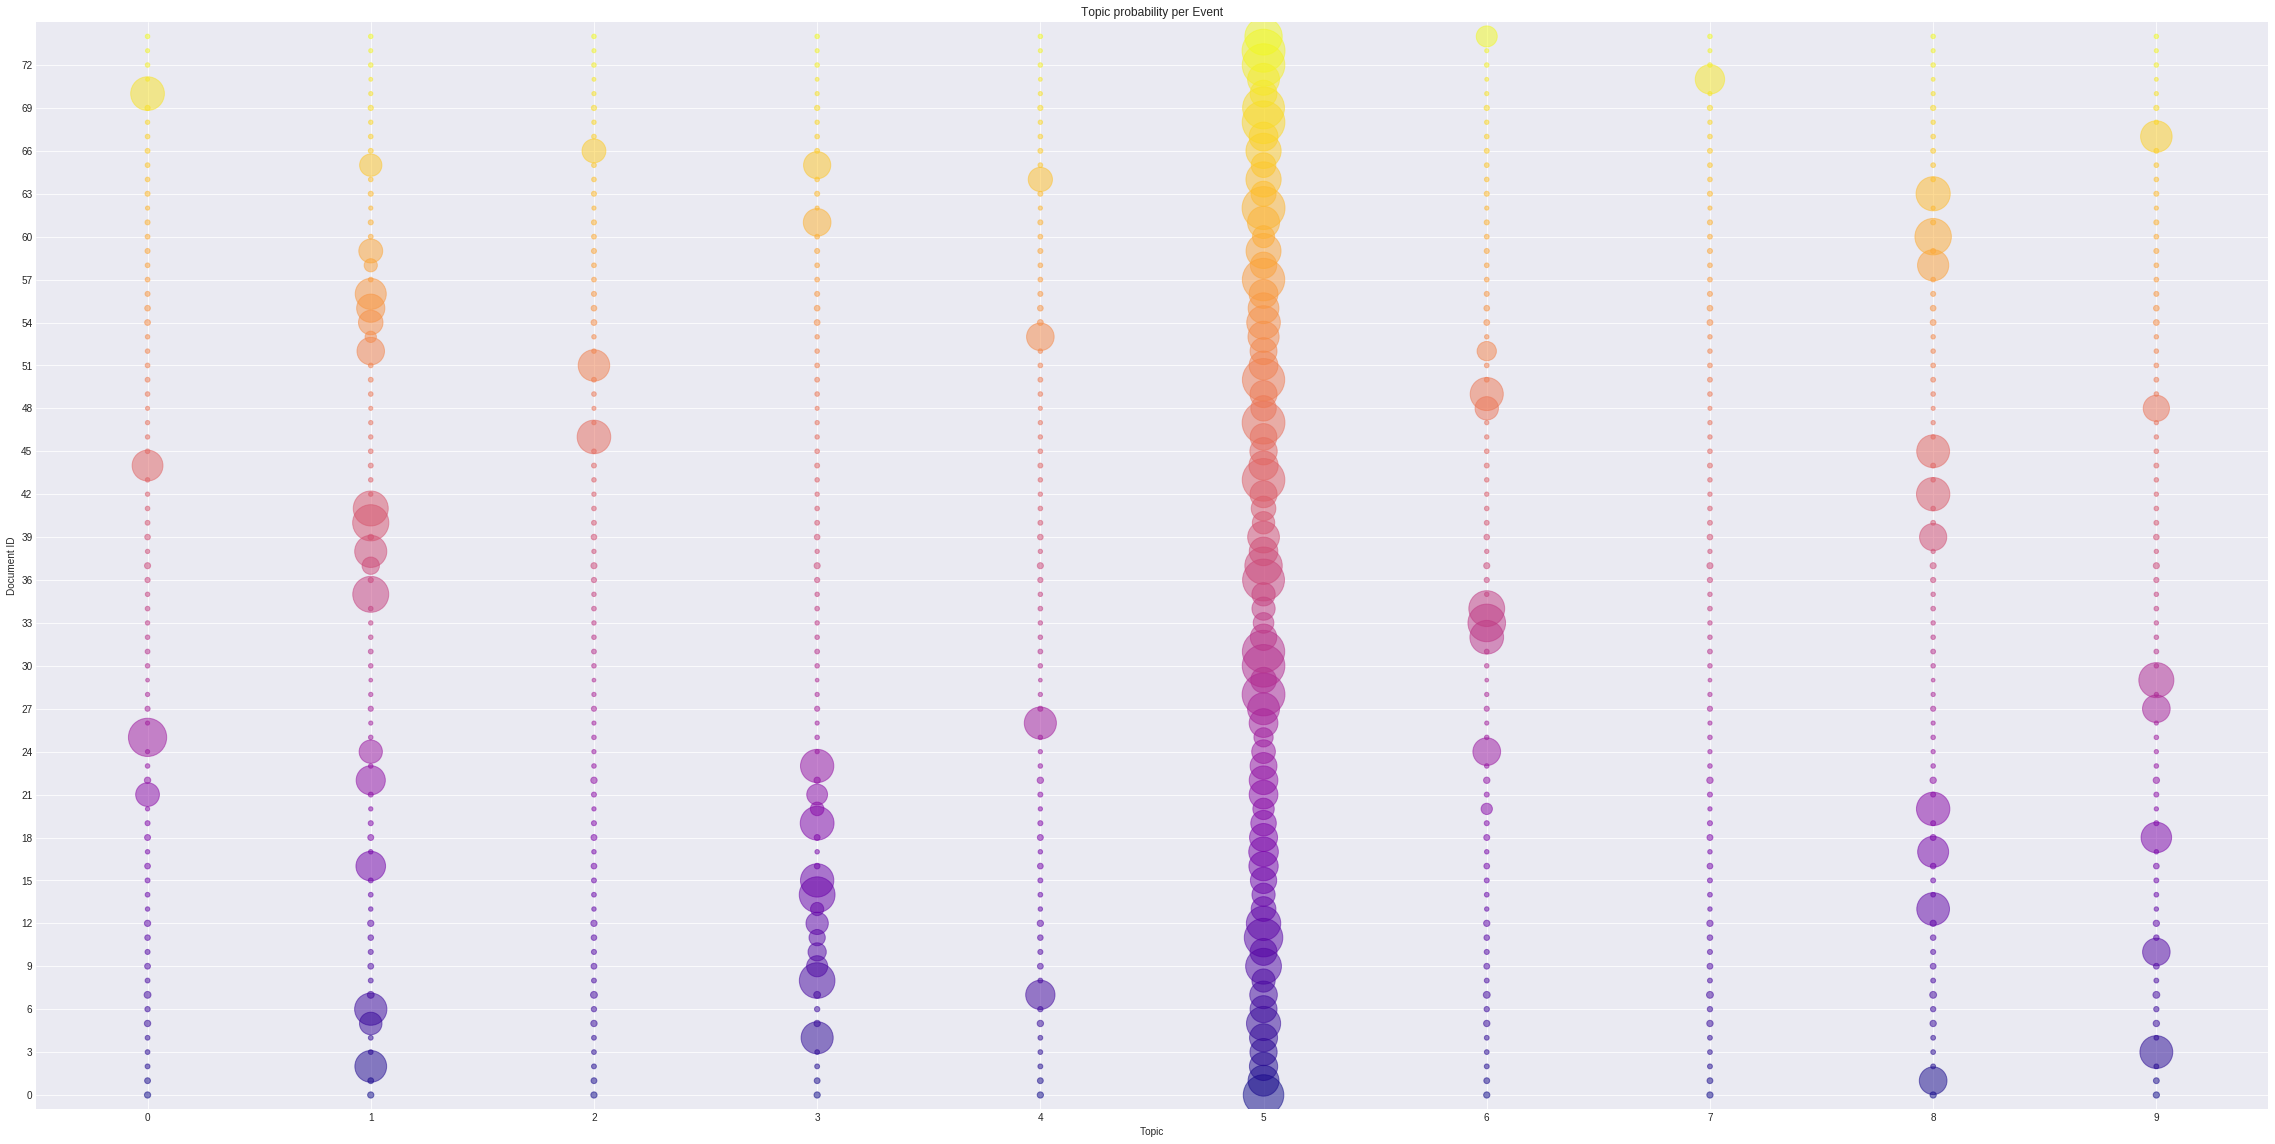

In [211]:
fig, ax = plt.subplots(figsize = (40,20))

for d_id, color in zip(pyl_topics['doc_id'], rgb_arr):
    mask = pyl_topics['doc_id'] == d_id
    ax.scatter(
        x = pyl_topics[mask]['topic_id'],
        y = pyl_topics[mask]['doc_id'],
        s = pyl_topics[mask]['likelihood']*2000,
        marker = 'o',
        alpha = 0.5,
        c = color
    #     cmap = 
    )
# Labels# 
ax.set_xlabel('Topic')
ax.set_ylabel('Document ID')
ax.set_title('Topic probability per Event')

# Axes 
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-1,75)
ax.set_xticks(range(number_topics))
ax.set_yticks(range(0,len(events), 3))

# Save
fig.savefig(IMG_FOLDER + 'topic_distrib_cmap.png')